# Task 4: Forecasting Access and Usage (2025–2027)

Forecast Account Ownership (Access) and Digital Payment Usage with baseline trend, event-augmented, and scenario analysis.

## 1. Load Data and Configure Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 100)

root = Path.cwd()
if not (root / "data").exists():
    root = root.parent

raw_path = root / "data" / "raw"
unified_path = raw_path / "ethiopia_fi_unified_data.csv"

unified = pd.read_csv(unified_path)
for col in ["observation_date", "period_start", "period_end"]:
    if col in unified.columns:
        unified[col] = pd.to_datetime(unified[col], errors="coerce")

unified["year"] = unified["observation_date"].dt.year

unified.head()

,record_id,parent_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year
0,REC_0001,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,2014.0
1,REC_0002,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2017.0
2,REC_0003,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2021.0
3,REC_0004,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021.0
4,REC_0005,NaN,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021.0


## 2. Define Targets (Access & Usage)

- Access: Account Ownership Rate (ACC_OWNERSHIP)
- Usage: Digital Payment Usage (USG_DIGITAL_PAYMENT if available; fallback to ACC_MM_ACCOUNT + USG_P2P_COUNT proxy)

In [2]:
obs = unified[unified["record_type"] == "observation"].copy()

access = obs[(obs["indicator_code"] == "ACC_OWNERSHIP") & (obs["gender"] == "all")]
access = access.dropna(subset=["year", "value_numeric"]).sort_values("year")

usage_candidates = ["USG_DIGITAL_PAYMENT", "ACC_MM_ACCOUNT"]
usage = obs[obs["indicator_code"].isin(usage_candidates)].copy()
usage = usage.dropna(subset=["year", "value_numeric"]).sort_values("year")

access[["year", "value_numeric", "source_name"]].tail()

,year,value_numeric,source_name
0,2014.0,22.0,Global Findex 2014
1,2017.0,35.0,Global Findex 2017
2,2021.0,46.0,Global Findex 2021
5,2024.0,49.0,Global Findex 2024


## 3. Baseline Trend Model (Linear) + Confidence Intervals

In [3]:
from sklearn.linear_model import LinearRegression

forecast_years = np.array([2025, 2026, 2027])

def fit_linear_forecast(df, label):
    X = df["year"].values.reshape(-1, 1)
    y = df["value_numeric"].values
    model = LinearRegression().fit(X, y)
    preds = model.predict(forecast_years.reshape(-1, 1))

    # Simple CI using residual std
    residuals = y - model.predict(X)
    sigma = residuals.std(ddof=1) if len(residuals) > 1 else 0
    ci_low = preds - 1.96 * sigma
    ci_high = preds + 1.96 * sigma

    out = pd.DataFrame({
        "year": forecast_years,
        f"{label}_forecast": preds,
        f"{label}_ci_low": ci_low,
        f"{label}_ci_high": ci_high,
    })
    return model, out

access_model, access_forecast = fit_linear_forecast(access, "access")
access_forecast

,year,access_forecast,access_ci_low,access_ci_high
0,2025,54.241379,48.581396,59.901363
1,2026,56.948276,51.288293,62.608259
2,2027,59.655172,53.995189,65.315156


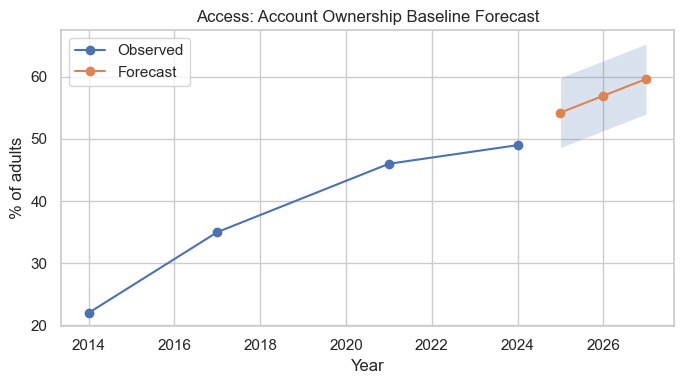

In [4]:
plt.figure(figsize=(7, 4))
plt.plot(access["year"], access["value_numeric"], marker="o", label="Observed")
plt.plot(access_forecast["year"], access_forecast["access_forecast"], marker="o", label="Forecast")
plt.fill_between(access_forecast["year"], access_forecast["access_ci_low"], access_forecast["access_ci_high"], alpha=0.2)
plt.title("Access: Account Ownership Baseline Forecast")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Usage Forecast (Fallback to Mobile Money Account Rate)

If `USG_DIGITAL_PAYMENT` is unavailable, use `ACC_MM_ACCOUNT` as a proxy.

In [5]:
usage_target = "USG_DIGITAL_PAYMENT"
usage_df = usage[usage["indicator_code"] == usage_target]

if usage_df.empty:
    usage_target = "ACC_MM_ACCOUNT"
    usage_df = usage[usage["indicator_code"] == usage_target]

usage_model, usage_forecast = fit_linear_forecast(usage_df, "usage")
usage_forecast

,year,usage_forecast,usage_ci_low,usage_ci_high
0,2025,11.033333,11.033333,11.033333
1,2026,12.616667,12.616667,12.616667
2,2027,14.200000,14.200000,14.200000


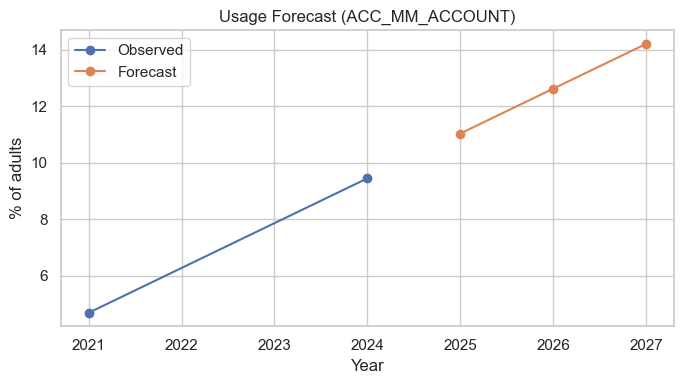

In [6]:
plt.figure(figsize=(7, 4))
plt.plot(usage_df["year"], usage_df["value_numeric"], marker="o", label="Observed")
plt.plot(usage_forecast["year"], usage_forecast["usage_forecast"], marker="o", label="Forecast")
plt.fill_between(usage_forecast["year"], usage_forecast["usage_ci_low"], usage_forecast["usage_ci_high"], alpha=0.2)
plt.title(f"Usage Forecast ({usage_target})")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Event-Augmented Forecast (Simple Additive Effects)

Use impact links to adjust baseline forecasts.

In [7]:
events = unified[unified["record_type"] == "event"].copy()
impact_links = unified[unified["record_type"] == "impact_link"].copy()

impact_join = impact_links.merge(
    events[["record_id", "indicator", "category", "observation_date"]],
    left_on="parent_id",
    right_on="record_id",
    how="left",
    suffixes=("", "_event")
)

magnitude_map = {"high": 0.15, "medium": 0.08, "low": 0.03, "negligible": 0.01}
direction_map = {"increase": 1, "decrease": -1, "stabilize": 0, "mixed": 0}

impact_model = impact_join.copy()
impact_model["effect_size"] = impact_model["impact_magnitude"].map(magnitude_map).fillna(0.0)
impact_model["direction_sign"] = impact_model["impact_direction"].map(direction_map).fillna(0.0)
impact_model["effect"] = impact_model["effect_size"] * impact_model["direction_sign"]
impact_model["lag_months_num"] = pd.to_numeric(impact_model["lag_months"], errors="coerce").fillna(0)


def event_effect_series(event_date, effect, lag_months=0, duration_years=3):
    if pd.isna(event_date):
        return pd.Series(dtype=float)
    lag_months = 0 if pd.isna(lag_months) else int(lag_months)
    start = (event_date + pd.DateOffset(months=lag_months)).year
    years = np.arange(start, start + duration_years)
    ramp = np.linspace(0.3, 1.0, duration_years)
    return pd.Series(effect * ramp, index=years)


def build_effects(target_code):
    effects = []
    subset = impact_model[impact_model["related_indicator"] == target_code]
    for _, row in subset.iterrows():
        series = event_effect_series(
            row.get("observation_date_event"),
            row.get("effect", 0.0),
            row.get("lag_months_num", 0)
        )
        for year, val in series.items():
            effects.append({"year": year, "effect": val})
    if not effects:
        return pd.Series(dtype=float)
    return pd.DataFrame(effects).groupby("year")["effect"].sum()

access_event_effects = build_effects("ACC_OWNERSHIP")
usage_event_effects = build_effects(usage_target)

access_aug = access_forecast.copy()
access_aug["event_effect"] = access_aug["year"].map(access_event_effects).fillna(0)
access_aug["access_forecast_event"] = access_aug["access_forecast"] + access_aug["event_effect"]

usage_aug = usage_forecast.copy()
usage_aug["event_effect"] = usage_aug["year"].map(usage_event_effects).fillna(0)
usage_aug["usage_forecast_event"] = usage_aug["usage_forecast"] + usage_aug["event_effect"]

access_aug, usage_aug

(   year  access_forecast  access_ci_low  access_ci_high  event_effect  \
 0  2025        54.241379      48.581396       59.901363           0.0   
 1  2026        56.948276      51.288293       62.608259           0.0   
 2  2027        59.655172      53.995189       65.315156           0.0   
 
    access_forecast_event  
 0              54.241379  
 1              56.948276  
 2              59.655172  ,
    year  usage_forecast  usage_ci_low  usage_ci_high  event_effect  \
 0  2025       11.033333     11.033333      11.033333           0.0   
 1  2026       12.616667     12.616667      12.616667           0.0   
 2  2027       14.200000     14.200000      14.200000           0.0   
 
    usage_forecast_event  
 0             11.033333  
 1             12.616667  
 2             14.200000  )

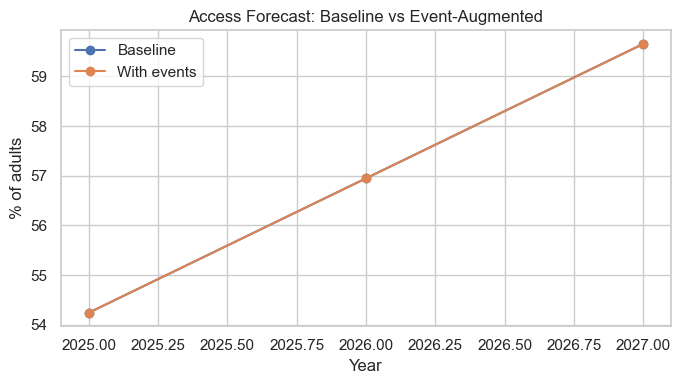

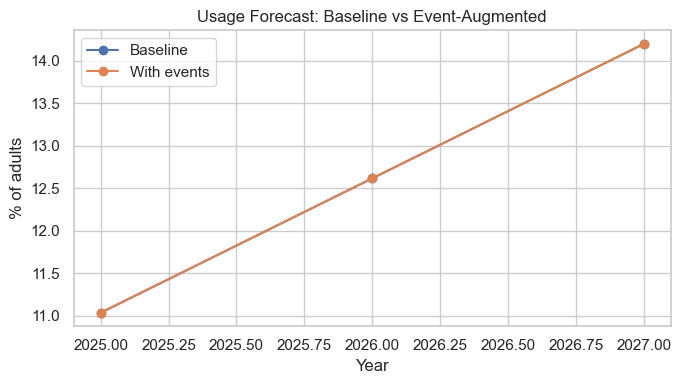

In [8]:
plt.figure(figsize=(7, 4))
plt.plot(access_forecast["year"], access_forecast["access_forecast"], marker="o", label="Baseline")
plt.plot(access_aug["year"], access_aug["access_forecast_event"], marker="o", label="With events")
plt.title("Access Forecast: Baseline vs Event-Augmented")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(usage_forecast["year"], usage_forecast["usage_forecast"], marker="o", label="Baseline")
plt.plot(usage_aug["year"], usage_aug["usage_forecast_event"], marker="o", label="With events")
plt.title("Usage Forecast: Baseline vs Event-Augmented")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

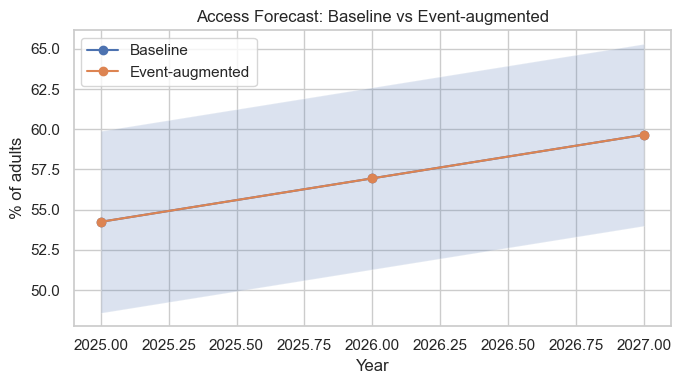

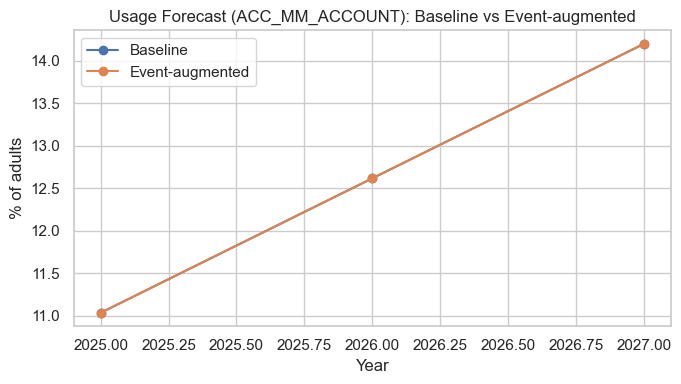

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(access_forecast["year"], access_forecast["access_forecast"], marker="o", label="Baseline")
plt.plot(access_aug["year"], access_aug["access_forecast_event"], marker="o", label="Event-augmented")
plt.fill_between(access_forecast["year"], access_forecast["access_ci_low"], access_forecast["access_ci_high"], alpha=0.2)
plt.title("Access Forecast: Baseline vs Event-augmented")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(usage_forecast["year"], usage_forecast["usage_forecast"], marker="o", label="Baseline")
plt.plot(usage_aug["year"], usage_aug["usage_forecast_event"], marker="o", label="Event-augmented")
plt.fill_between(usage_forecast["year"], usage_forecast["usage_ci_low"], usage_forecast["usage_ci_high"], alpha=0.2)
plt.title(f"Usage Forecast ({usage_target}): Baseline vs Event-augmented")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Scenario Forecasts (Optimistic / Base / Pessimistic)

Scale baseline forecasts to reflect different adoption paths.

In [10]:
scenario_factors = {"pessimistic": 0.85, "base": 1.0, "optimistic": 1.15}

def apply_scenarios(forecast_df, col):
    out = forecast_df[["year", col]].copy()
    for name, factor in scenario_factors.items():
        out[name] = out[col] * factor
    return out

access_scenarios = apply_scenarios(access_forecast, "access_forecast")
usage_scenarios = apply_scenarios(usage_forecast, "usage_forecast")

access_scenarios

,year,access_forecast,pessimistic,base,optimistic
0,2025,54.241379,46.105172,54.241379,62.377586
1,2026,56.948276,48.406034,56.948276,65.490517
2,2027,59.655172,50.706897,59.655172,68.603448


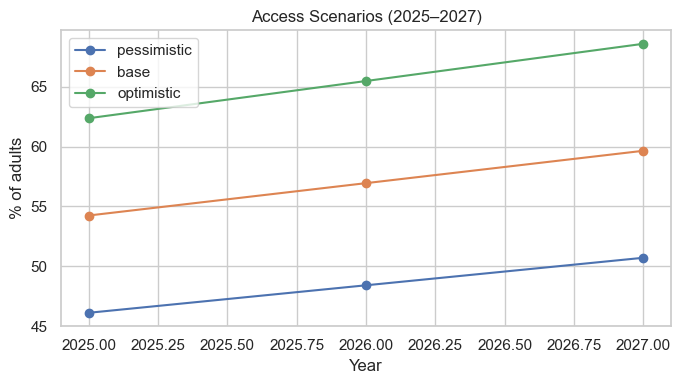

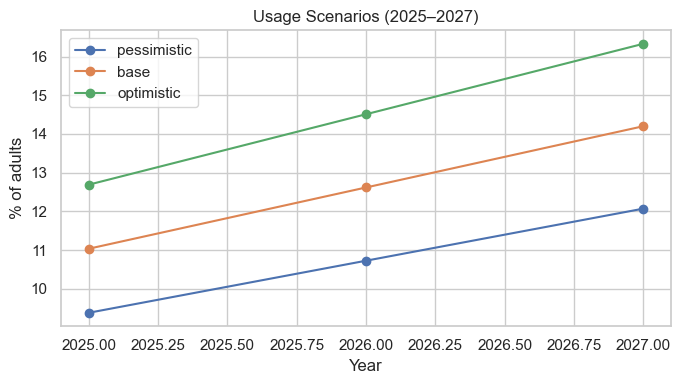

In [11]:
plt.figure(figsize=(7, 4))
for scenario in ["pessimistic", "base", "optimistic"]:
    plt.plot(access_scenarios["year"], access_scenarios[scenario], marker="o", label=scenario)
plt.title("Access Scenarios (2025–2027)")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
for scenario in ["pessimistic", "base", "optimistic"]:
    plt.plot(usage_scenarios["year"], usage_scenarios[scenario], marker="o", label=scenario)
plt.title("Usage Scenarios (2025–2027)")
plt.xlabel("Year")
plt.ylabel("% of adults")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Forecast Tables with Confidence Intervals

In [12]:
forecast_table = access_forecast.merge(usage_forecast, on="year", how="outer")
forecast_table

,year,access_forecast,access_ci_low,access_ci_high,usage_forecast,usage_ci_low,usage_ci_high
0,2025,54.241379,48.581396,59.901363,11.033333,11.033333,11.033333
1,2026,56.948276,51.288293,62.608259,12.616667,12.616667,12.616667
2,2027,59.655172,53.995189,65.315156,14.200000,14.200000,14.200000


## 8. Interpretation and Key Uncertainties

- Baseline trend reflects limited Findex points; forecasts are sensitive to outliers.
- Event-augmented model assumes additive effects and simplified lags.
- Usage forecast may rely on mobile money proxy if direct digital payment data is missing.
- Key uncertainties: data sparsity, policy timing, macroeconomic shocks, and regulatory shifts.

## 9. Export Forecast Outputs

Save forecast tables for reporting.

In [13]:
output_dir = root / "reports"
output_dir.mkdir(parents=True, exist_ok=True)
forecast_table.to_csv(output_dir / "task4_forecast_table.csv", index=False)
access_scenarios.to_csv(output_dir / "task4_access_scenarios.csv", index=False)
usage_scenarios.to_csv(output_dir / "task4_usage_scenarios.csv", index=False)
print("Saved forecast tables to reports/")

Saved forecast tables to reports/
